TODO
1. extract features by googlenet
2. compute similarity
3. test on Place dataset

## Feature extraction

In [2]:
database = "images/Nordland_data"
query = "images/Nordland_query"

### Using GoogLenet

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from googlenet_places205 import GoogLeNetPlaces205
model = GoogLeNetPlaces205()
model.load_state_dict(torch.load("googlenet_places205.pth"))

# from googlenet_places365 import GoogLeNetPlaces365
# model = GoogLeNetPlaces365()
# model.load_state_dict(torch.load("googlenet_places365.pth"))

features = {}


def get_middle_output(name):
    def hook(model, input, output):
        features[name] = (input[0].detach())
    return hook


model.inception_3b_3x3_reduce.register_forward_hook(get_middle_output('icp1'))


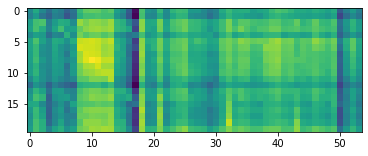

In [4]:
import os
from PIL import Image
from torchvision import transforms


def preprocess_singe_img(filename):
    input_image = Image.open(filename)
    transform = transforms.Compose([
        transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225]),
    ])
    input_tensor = transform(input_image)
    # create a mini-batch as expected by the model
    input_batch = input_tensor.unsqueeze(0)
    return input_batch, np.array(input_image)


def get_features(input):
    output = model(input)
    return features['icp1'].flatten()


def get_similarity(input1, input2):
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    return cos(input1, input2)


def process_images_from_folder(folder):
    image_features = []
    images = []
    dir_list = sorted(os.listdir(folder))
    for filename in dir_list:
        if filename is not None:
            input, image = preprocess_singe_img(folder + '/' + filename)
            images.append(image)
            image_features.append(get_features(input))
    return image_features, images


database_features, database_images = process_images_from_folder(database)
query_features, query_images = process_images_from_folder(query)

similarity_matrix = np.zeros(
    (len(query_features), len(database_features)))  # Q by D

for i in range(len(query_features)):
    for j in range(len(database_features)):
        similarity_matrix[i][j] = get_similarity(
            query_features[i], database_features[j])

plt.imshow(similarity_matrix)
plt.show()


### Using HOG

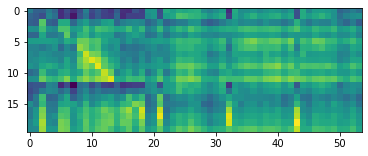

In [5]:
from skimage.feature import hog
from skimage import exposure


def hog_preprocess_singe_img(filename):
    input_image = Image.open(filename)
    transform = transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225]),
        transforms.Grayscale(num_output_channels=1),
    ])
    input_tensor = transform(input_image)
    # input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    return input_tensor, np.array(input_image)


def get_hog_features(input):
    fd = hog(input.squeeze(), orientations=10, pixels_per_cell=(32, 32),
             cells_per_block=(2, 2))
    return fd


def hog_process_images_from_folder(folder):
    image_features = []
    images = []
    dir_list = sorted(os.listdir(folder))
    for filename in dir_list:
        if (filename is not None):
            input, image = hog_preprocess_singe_img(folder + '/' + filename)
            image_features.append(get_hog_features(input))
            images.append(image)
    return image_features, images


hog_database_features, hog_database_images = hog_process_images_from_folder(
    database)
hog_query_features, hog_query_images = hog_process_images_from_folder(query)

hog_similarity_matrix = np.zeros(
    (len(hog_query_features), len(hog_database_features)))  # Q by D

for i in range(len(hog_query_features)):
    for j in range(len(hog_database_features)):
        hog_similarity_matrix[i][j] = get_similarity(torch.from_numpy(
            hog_query_features[i]), torch.from_numpy(hog_database_features[j]))

plt.imshow(hog_similarity_matrix)
plt.show()


Show pictures

In [6]:
def visualize(database_images, query_images, similarity_matrix, query_num=10):
    matches = np.argmax(similarity_matrix, axis=1)
    # query_num=len(query_images)
    fig, ax = plt.subplots(query_num, 2, figsize=(8, 60))
    fig.tight_layout()
    for i in range(query_num):
        ax[i, 0].imshow(query_images[i])
        ax[i, 0].set_title(i)
        ax[i, 1].imshow(database_images[matches[i]])
        ax[i, 1].set_title(matches[i])
    fig.show()

# visualize(hog_database_images,hog_query_images,hog_similarity_matrix)
# visualize(database_images,query_images,similarity_matrix)


## Minumum flow

In [7]:
import networkx as nx

In [8]:
# # An example of min cost flow
# G = nx.DiGraph()
# G.add_node("a", demand=-5)
# G.add_node("d", demand=5)
# G.add_edge("a", "b", weight=3, capacity=4)
# G.add_edge("a", "c", weight=6, capacity=10)
# G.add_edge("b", "d", weight=1, capacity=9)
# G.add_edge("c", "d", weight=2, capacity=5)
# flowDict = nx.min_cost_flow(G)
# print(flowDict)


In [9]:
# Generate the graph
def minCostFlow(similarity_matrix):
    # Definie our problem
    G = nx.DiGraph()

    # Size of query and data
    Q = similarity_matrix.shape[0]
    D = similarity_matrix.shape[1]

    F = 5  # Flow
    K = 4  # Span

    w_h = 1  # weight for connecting hidden units

    G.add_node("s", demand=-F)
    G.add_node("t", demand=F)

    # Episolon s
    for j in range(1, D+1):
        G.add_edge("s", (1, j), weight=0, capacity=1)
        G.add_edge("s", (-1, -j), weight=0, capacity=1)

    # Episolon t
    for j in range(1, D+1):
        G.add_edge((Q, j), "t", weight=0, capacity=1)
        G.add_edge((-Q, -j), "t", weight=0, capacity=1)

    # Episolon a and b
    for i in range(1, Q):
        for j in range(1, D+1):
            for k in range(j, min(max(j+K, D), D+1)):
                # print(k)
                G.add_edge((i, j), (i+1, k), weight=1 /
                           similarity_matrix[i-1][j-1], capacity=1)
                G.add_edge((-i, -j), (-i-1, -k), weight=1 /
                           similarity_matrix[i-1][j-1], capacity=1)
                G.add_edge((i, j), (-i-1, -k), weight=1 /
                           similarity_matrix[i-1][j-1], capacity=1)
                G.add_edge((-i, -j), (i+1, k), weight=1 /
                           similarity_matrix[i-1][j-1], capacity=1)
                # G.add_edge((i,j), (i+1,k), weight=0, capacity=1)
                # G.add_edge((-i,-j), (-i-1,-k), weight=0, capacity=1)
                # G.add_edge((i,j), (-i-1,-k), weight=0, capacity=1)
                # G.add_edge((-i,-j), (i+1,k), weight=0, capacity=1)

    # Episolon h
    for i in range(1, Q+1):
        for j in range(1, D-1):
            G.add_edge((i, j), (i, j+1), weight=0, capacity=1)
            G.add_edge((i, j), (-i, -j-1), weight=0, capacity=1)
            G.add_edge((-i, -j), (i, j+1), weight=0, capacity=1)
            G.add_edge((-i, -j), (-i, -j-1), weight=0, capacity=1)
    return G


In [10]:
G = minCostFlow(hog_similarity_matrix)
print(G.number_of_edges())

113436


In [11]:
# min cost flow solution
# flowDict = nx.min_cost_flow(G)
# print(flowDict)

In [12]:
if nx.is_directed_acyclic_graph(G):
    print(list(reversed(list(nx.topological_sort(G)))))


['t', (20, 53), (-20, -53), (20, 52), (-20, -52), (20, 51), (-20, -51), (20, 50), (-20, -50), (20, 49), (-20, -49), (20, 48), (-20, -48), (20, 47), (-20, -47), (20, 46), (-20, -46), (20, 45), (-20, -45), (20, 44), (-20, -44), (20, 43), (-20, -43), (20, 42), (-20, -42), (20, 41), (-20, -41), (20, 40), (-20, -40), (20, 39), (-20, -39), (20, 38), (-20, -38), (20, 37), (-20, -37), (20, 36), (-20, -36), (20, 35), (-20, -35), (20, 34), (-20, -34), (20, 33), (-20, -33), (20, 32), (-20, -32), (20, 31), (-20, -31), (20, 30), (-20, -30), (20, 29), (-20, -29), (20, 28), (-20, -28), (20, 27), (-20, -27), (20, 26), (-20, -26), (20, 25), (-20, -25), (20, 24), (-20, -24), (20, 23), (-20, -23), (20, 22), (-20, -22), (20, 21), (-20, -21), (20, 20), (-20, -20), (20, 19), (-20, -19), (20, 18), (-20, -18), (20, 17), (-20, -17), (20, 16), (-20, -16), (20, 15), (-20, -15), (20, 14), (-20, -14), (20, 13), (-20, -13), (20, 12), (-20, -12), (20, 11), (-20, -11), (20, 10), (-20, -10), (20, 9), (-20, -9), (20, 8

In [13]:
def visualizeList(database_images, query_images, shortest_list):
    query_num = len(shortest_list)-2
    # query_num=len(query_images)
    fig, ax = plt.subplots(query_num, 2, figsize=(8, 60))
    fig.tight_layout()
    for i in range(query_num):
        ax[i, 0].imshow(query_images[i])
        ax[i, 0].set_title(i)
        ax[i, 1].imshow(database_images[shortest_list[i+1][1]-1])
        ax[i, 1].set_title(shortest_list[i+1][1]-1)
    fig.show()


In [14]:
# nx.draw_networkx(G)
# nx.write_gexf(G, "test.gexf")


In [20]:
# for u in flowDict:
#     for v in flowDict[u]:
#         if flowDict[u][v]>0:
#             print(u,v)

# list_flow = [(u, v)
#              for u in flowDict for v in flowDict[u] if flowDict[u][v] > 0]


['s', (1, 1), (2, 4), (3, 7), (4, 7), (5, 7), (6, 9), (7, 9), (8, 10), (9, 11), (10, 12), (11, 13), (12, 14), (13, 25), (14, 25), (15, 33), (16, 33), (17, 33), (18, 33), (19, 44), (20, 44), 't']


C:\Users\ranba\AppData\Local\Temp\ipykernel_8284\895853173.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


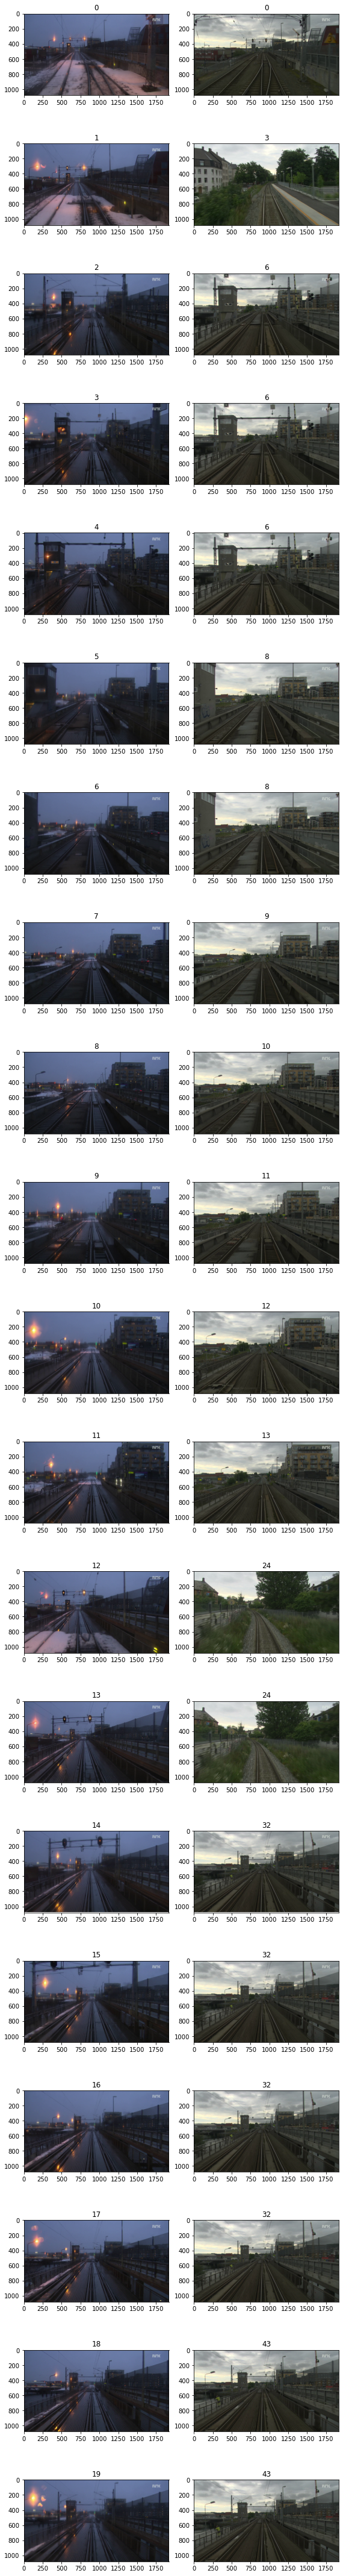

In [18]:
shortest_list = nx.shortest_path(G, "s", "t", weight="weight")
print(shortest_list)

visualizeList(database_images, query_images, shortest_list)


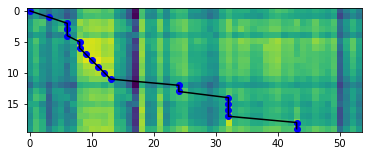

In [19]:

def visualization(shortest_list, similarity_matrix):
    query = []
    data = []
    for i in range(1, len(shortest_list)-1):
        query.append(shortest_list[i][0]-1)
        data.append(shortest_list[i][1]-1)
    plt.imshow(similarity_matrix)
    plt.scatter(data, query, color='b')
    plt.plot(data, query, color='black')
    plt.show()


visualization(shortest_list, similarity_matrix)
